In [5]:
# Import required libraries
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scikit_posthocs as sp
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load all model JSON files
models = ['SVM', 'RandomForest', 'NeuralNetwork', 'XGBoost']
model_data = {}

for model in models:
    try:
        filename = f'results/{model}_validation_results.json'
        with open(filename, 'r') as f:
            model_data[model] = json.load(f)
        print(f"✓ Successfully loaded {model}")
    except FileNotFoundError:
        print(f"✗ File not found: {filename}")
        model_data[model] = None

# Create DataFrames for each model
model_dfs = {}
for model_name, data in model_data.items():
    if data is not None:
        model_dfs[model_name] = pd.DataFrame({
            'Model': model_name,
            'Fold': range(1, len(data['metrics_summary']['f2_scores']) + 1),
            'F2_Score': data['metrics_summary']['f2_scores'],
            'F1_Score': data['metrics_summary']['f1_scores'],
            'Accuracy': data['metrics_summary']['accuracy_scores'],
            'Precision': data['metrics_summary'].get('precision_scores', [0]*20),
            'Recall': data['metrics_summary'].get('recall_scores', [0]*20)
        })

# Combine all models into a single DataFrame
all_models_df = pd.concat(model_dfs.values(), ignore_index=True)

print(f"\nLoaded {len(model_dfs)} models:")
for model in model_dfs.keys():
    print(f"  - {model}: {len(model_dfs[model])} folds")

✓ Successfully loaded SVM
✓ Successfully loaded RandomForest
✓ Successfully loaded NeuralNetwork
✓ Successfully loaded XGBoost

Loaded 4 models:
  - SVM: 20 folds
  - RandomForest: 20 folds
  - NeuralNetwork: 20 folds
  - XGBoost: 20 folds


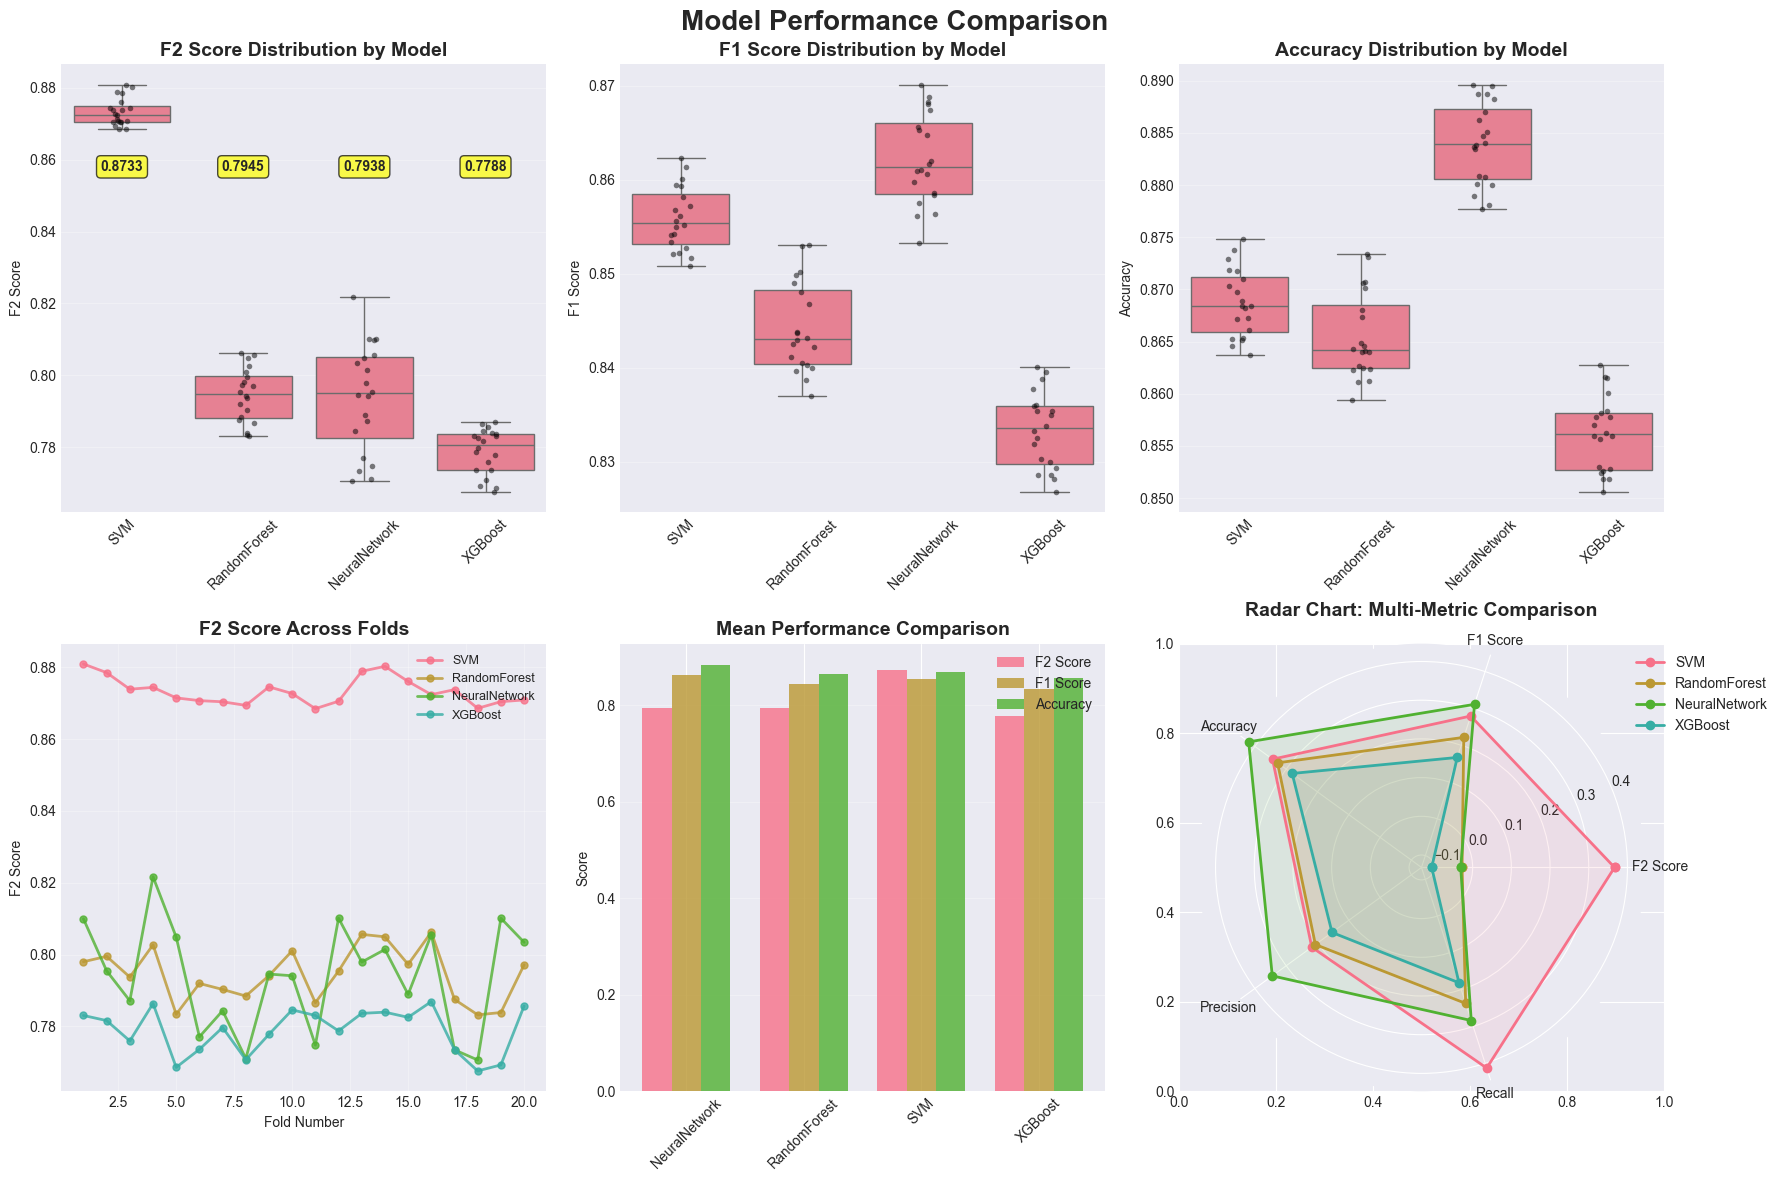


Model Performance Summary (Mean ± Std):
--------------------------------------------------

NeuralNetwork:
  F2_Score    : 0.7938 ± 0.0150
  F1_Score    : 0.8622 ± 0.0048
  Accuracy    : 0.8840 ± 0.0039

RandomForest:
  F2_Score    : 0.7945 ± 0.0075
  F1_Score    : 0.8443 ± 0.0048
  Accuracy    : 0.8655 ± 0.0041

SVM:
  F2_Score    : 0.8733 ± 0.0038
  F1_Score    : 0.8559 ± 0.0034
  Accuracy    : 0.8687 ± 0.0032

XGBoost:
  F2_Score    : 0.7788 ± 0.0063
  F1_Score    : 0.8333 ± 0.0040
  Accuracy    : 0.8562 ± 0.0036


In [6]:
# Create comprehensive comparison visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Model Performance Comparison', fontsize=20, fontweight='bold')

# 1. F2 Score Boxplot by Model
sns.boxplot(x='Model', y='F2_Score', data=all_models_df, ax=axes[0, 0])
sns.stripplot(x='Model', y='F2_Score', data=all_models_df, 
              ax=axes[0, 0], color='black', alpha=0.5, size=4)
axes[0, 0].set_title('F2 Score Distribution by Model', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('F2 Score')
axes[0, 0].set_xlabel('')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Add mean values on boxplot
for i, model in enumerate(all_models_df['Model'].unique()):
    mean_val = all_models_df[all_models_df['Model'] == model]['F2_Score'].mean()
    axes[0, 0].text(i, axes[0, 0].get_ylim()[1]*0.97, f'{mean_val:.4f}', 
                    ha='center', va='top', fontweight='bold', 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

# 2. F1 Score Boxplot by Model
sns.boxplot(x='Model', y='F1_Score', data=all_models_df, ax=axes[0, 1])
sns.stripplot(x='Model', y='F1_Score', data=all_models_df, 
              ax=axes[0, 1], color='black', alpha=0.5, size=4)
axes[0, 1].set_title('F1 Score Distribution by Model', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].set_xlabel('')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Accuracy Boxplot by Model
sns.boxplot(x='Model', y='Accuracy', data=all_models_df, ax=axes[0, 2])
sns.stripplot(x='Model', y='Accuracy', data=all_models_df, 
              ax=axes[0, 2], color='black', alpha=0.5, size=4)
axes[0, 2].set_title('Accuracy Distribution by Model', fontsize=14, fontweight='bold')
axes[0, 2].set_ylabel('Accuracy')
axes[0, 2].set_xlabel('')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].grid(True, alpha=0.3, axis='y')

# 4. Performance over folds (F2 Score)
for model in all_models_df['Model'].unique():
    model_df = all_models_df[all_models_df['Model'] == model]
    axes[1, 0].plot(model_df['Fold'], model_df['F2_Score'], 'o-', 
                    label=model, alpha=0.8, linewidth=2, markersize=5)
axes[1, 0].set_title('F2 Score Across Folds', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Fold Number')
axes[1, 0].set_ylabel('F2 Score')
axes[1, 0].legend(loc='upper right', fontsize=9)
axes[1, 0].grid(True, alpha=0.3)

# 5. Mean performance comparison bar chart
mean_performance = all_models_df.groupby('Model')[['F2_Score', 'F1_Score', 'Accuracy']].mean()
x = np.arange(len(mean_performance))
width = 0.25

axes[1, 1].bar(x - width, mean_performance['F2_Score'], width, label='F2 Score', alpha=0.8)
axes[1, 1].bar(x, mean_performance['F1_Score'], width, label='F1 Score', alpha=0.8)
axes[1, 1].bar(x + width, mean_performance['Accuracy'], width, label='Accuracy', alpha=0.8)

axes[1, 1].set_title('Mean Performance Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(mean_performance.index, rotation=45)
axes[1, 1].legend(loc='upper right')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# 6. Radar chart for multi-metric comparison
ax_radar = fig.add_subplot(2, 3, 6, projection='polar')
categories = ['F2 Score', 'F1 Score', 'Accuracy', 'Precision', 'Recall']
N = len(categories)

# Normalize values for radar chart
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Close the circle

for model in all_models_df['Model'].unique():
    model_df = all_models_df[all_models_df['Model'] == model]
    values = [
        model_df['F2_Score'].mean(),
        model_df['F1_Score'].mean(),
        model_df['Accuracy'].mean(),
        model_df['Precision'].mean(),
        model_df['Recall'].mean()
    ]
    # Normalize to 0-1 range for better visualization
    values_normalized = [(v - 0.8) / 0.2 for v in values]  # Assuming scores between 0.8-1.0
    values_normalized += values_normalized[:1]
    
    ax_radar.plot(angles, values_normalized, 'o-', linewidth=2, label=model)
    ax_radar.fill(angles, values_normalized, alpha=0.1)

ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels(categories)
ax_radar.set_title('Radar Chart: Multi-Metric Comparison', fontsize=14, fontweight='bold', pad=20)
ax_radar.grid(True)
ax_radar.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nModel Performance Summary (Mean ± Std):")
print("-" * 50)
for model in sorted(all_models_df['Model'].unique()):
    model_df = all_models_df[all_models_df['Model'] == model]
    print(f"\n{model}:")
    for metric in ['F2_Score', 'F1_Score', 'Accuracy']:
        mean_val = model_df[metric].mean()
        std_val = model_df[metric].std()
        print(f"  {metric:12s}: {mean_val:.4f} ± {std_val:.4f}")

Shapiro-Wilk Normality Tests for All Models

SVM:
----------------------------------------
  F2_Score    : ✓ NORMAL (p=0.0781, W=0.9146)
  F1_Score    : ✓ NORMAL (p=0.5277, W=0.9592)
  Accuracy    : ✓ NORMAL (p=0.6394, W=0.9646)

RandomForest:
----------------------------------------
  F2_Score    : ✓ NORMAL (p=0.3593, W=0.9495)
  F1_Score    : ✓ NORMAL (p=0.1629, W=0.9312)
  Accuracy    : ✓ NORMAL (p=0.0759, W=0.9140)

NeuralNetwork:
----------------------------------------
  F2_Score    : ✓ NORMAL (p=0.3726, W=0.9504)
  F1_Score    : ✓ NORMAL (p=0.5615, W=0.9609)
  Accuracy    : ✓ NORMAL (p=0.2014, W=0.9360)

XGBoost:
----------------------------------------
  F2_Score    : ✓ NORMAL (p=0.0619, W=0.9093)
  F1_Score    : ✓ NORMAL (p=0.4389, W=0.9544)
  Accuracy    : ✓ NORMAL (p=0.3048, W=0.9456)

STATISTICAL TEST RECOMMENDATIONS FOR PAIRED COMPARISONS

Comparison: SVM vs RandomForest
----------------------------------------
  SVM normality: Normal
  RandomForest normality: Normal
  Dif

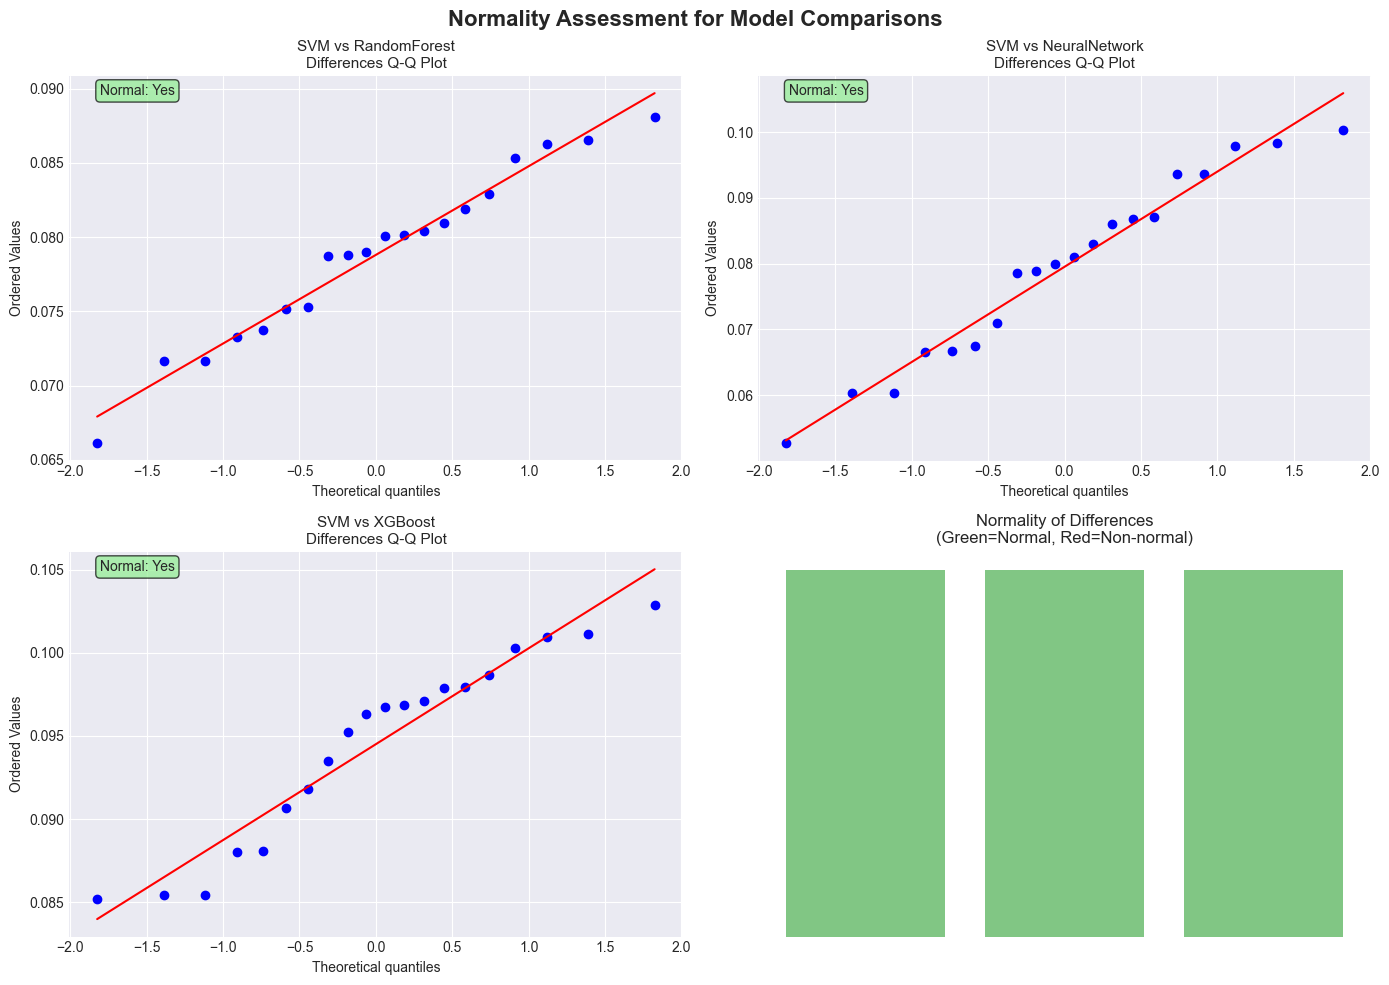

In [7]:
# Perform Shapiro-Wilk tests for each model and metric
print("Shapiro-Wilk Normality Tests for All Models")
print("=" * 70)

shapiro_results = {}
for model in all_models_df['Model'].unique():
    model_df = all_models_df[all_models_df['Model'] == model]
    shapiro_results[model] = {}
    
    print(f"\n{model}:")
    print("-" * 40)
    
    for metric in ['F2_Score', 'F1_Score', 'Accuracy']:
        stat, p_value = stats.shapiro(model_df[metric])
        shapiro_results[model][metric] = {'statistic': stat, 'p_value': p_value, 'normal': p_value > 0.05}
        
        status = "✓ NORMAL" if p_value > 0.05 else "✗ NON-NORMAL"
        print(f"  {metric:12s}: {status} (p={p_value:.4f}, W={stat:.4f})")

# Determine which tests to use based on normality
print("\n" + "=" * 70)
print("STATISTICAL TEST RECOMMENDATIONS FOR PAIRED COMPARISONS")
print("=" * 70)

# We'll compare SVM against each other model
comparison_pairs = [
    ('SVM', 'RandomForest'),
    ('SVM', 'NeuralNetwork'),
    ('SVM', 'XGBoost')
]

test_recommendations = {}

for model1, model2 in comparison_pairs:
    print(f"\nComparison: {model1} vs {model2}")
    print("-" * 40)
    
    # Check normality for both models' F2 scores
    model1_normal = shapiro_results[model1]['F2_Score']['normal']
    model2_normal = shapiro_results[model2]['F2_Score']['normal']
    
    # Check normality of differences
    model1_f2 = all_models_df[all_models_df['Model'] == model1]['F2_Score'].values
    model2_f2 = all_models_df[all_models_df['Model'] == model2]['F2_Score'].values
    differences = model1_f2 - model2_f2
    
    diff_stat, diff_p = stats.shapiro(differences)
    diff_normal = diff_p > 0.05
    
    print(f"  {model1} normality: {'Normal' if model1_normal else 'Non-normal'}")
    print(f"  {model2} normality: {'Normal' if model2_normal else 'Non-normal'}")
    print(f"  Differences normality: {'Normal' if diff_normal else 'Non-normal'} (p={diff_p:.4f})")
    
    # Recommendation logic
    if diff_normal:
        recommended_test = "Paired t-test"
        alternative_test = "Wilcoxon signed-rank test"
    else:
        recommended_test = "Wilcoxon signed-rank test"
        alternative_test = "Paired t-test (if assumptions are met)"
    
    test_recommendations[(model1, model2)] = {
        'recommended': recommended_test,
        'alternative': alternative_test,
        'diff_normal': diff_normal
    }
    
    print(f"  Recommended test: {recommended_test}")
    print(f"  Alternative test: {alternative_test}")

# Visualize normality results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Normality Assessment for Model Comparisons', fontsize=16, fontweight='bold')

# Plot 1: Q-Q plots for differences
for idx, (model1, model2) in enumerate(comparison_pairs):
    row, col = divmod(idx, 2)
    model1_f2 = all_models_df[all_models_df['Model'] == model1]['F2_Score'].values
    model2_f2 = all_models_df[all_models_df['Model'] == model2]['F2_Score'].values
    differences = model1_f2 - model2_f2
    
    stats.probplot(differences, dist="norm", plot=axes[row, col])
    axes[row, col].set_title(f'{model1} vs {model2}\nDifferences Q-Q Plot', fontsize=11)
    
    # Add normality indicator
    diff_normal = test_recommendations[(model1, model2)]['diff_normal']
    color = 'lightgreen' if diff_normal else 'lightcoral'
    axes[row, col].text(0.05, 0.95, f'Normal: {"Yes" if diff_normal else "No"}', 
                       transform=axes[row, col].transAxes, fontsize=10,
                       bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.7))

# Hide empty subplot
axes[1, 1].axis('off')

# Plot 2: Normality summary
ax_summary = axes[1, 1]
normality_summary = []
for model1, model2 in comparison_pairs:
    diff_normal = test_recommendations[(model1, model2)]['diff_normal']
    normality_summary.append({
        'Comparison': f'{model1}\nvs\n{model2}',
        'Normal': diff_normal
    })

summary_df = pd.DataFrame(normality_summary)
colors = ['#4CAF50' if n else '#F44336' for n in summary_df['Normal']]

ax_summary.bar(range(len(summary_df)), [1]*len(summary_df), color=colors, alpha=0.7)
ax_summary.set_xticks(range(len(summary_df)))
ax_summary.set_xticklabels(summary_df['Comparison'], rotation=0)
ax_summary.set_yticks([])
ax_summary.set_title('Normality of Differences\n(Green=Normal, Red=Non-normal)', fontsize=12)
ax_summary.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

OVERALL MODEL COMPARISON TEST

All models have normally distributed F2 scores.
Performing One-Way Repeated Measures ANOVA...

Repeated Measures ANOVA Results:
               Anova
      F Value  Num DF  Den DF Pr > F
------------------------------------
model 701.3212 3.0000 57.0000 0.0000



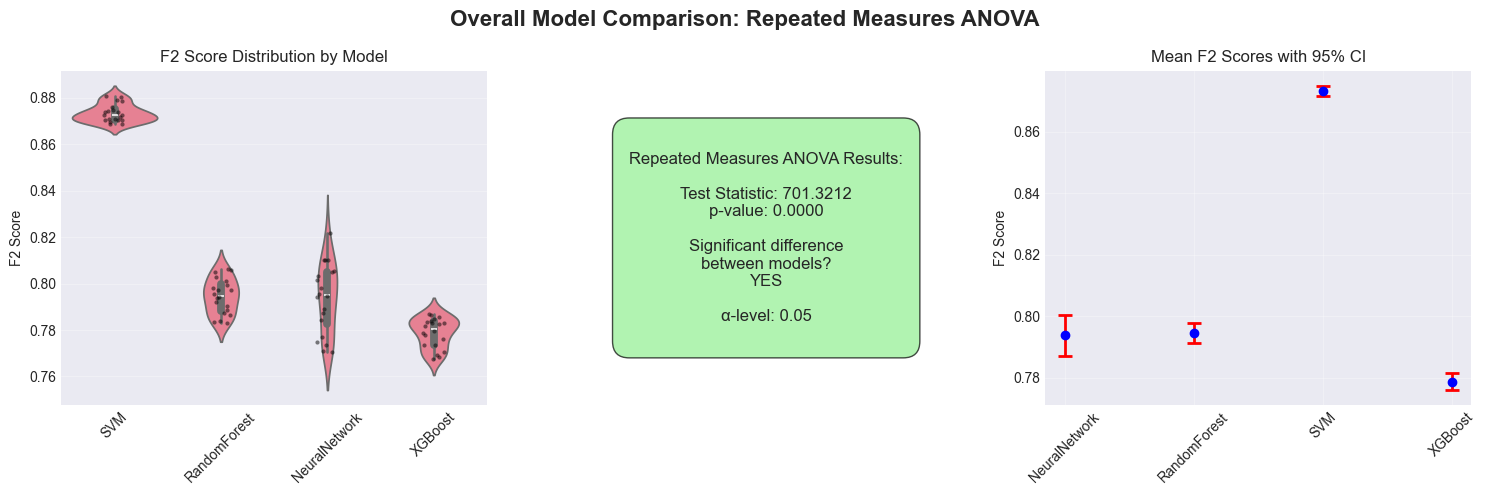


POST-HOC ANALYSIS (Overall test was significant)

Performing Tukey HSD post-hoc test...
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
    group1       group2    meandiff p-adj   lower   upper  reject
-----------------------------------------------------------------
NeuralNetwork RandomForest   0.0007 0.9946 -0.0069  0.0083  False
NeuralNetwork          SVM   0.0795    0.0  0.0719  0.0871   True
NeuralNetwork      XGBoost   -0.015    0.0 -0.0226 -0.0074   True
 RandomForest          SVM   0.0788    0.0  0.0712  0.0864   True
 RandomForest      XGBoost  -0.0157    0.0 -0.0233 -0.0081   True
          SVM      XGBoost  -0.0945    0.0 -0.1021 -0.0869   True
-----------------------------------------------------------------


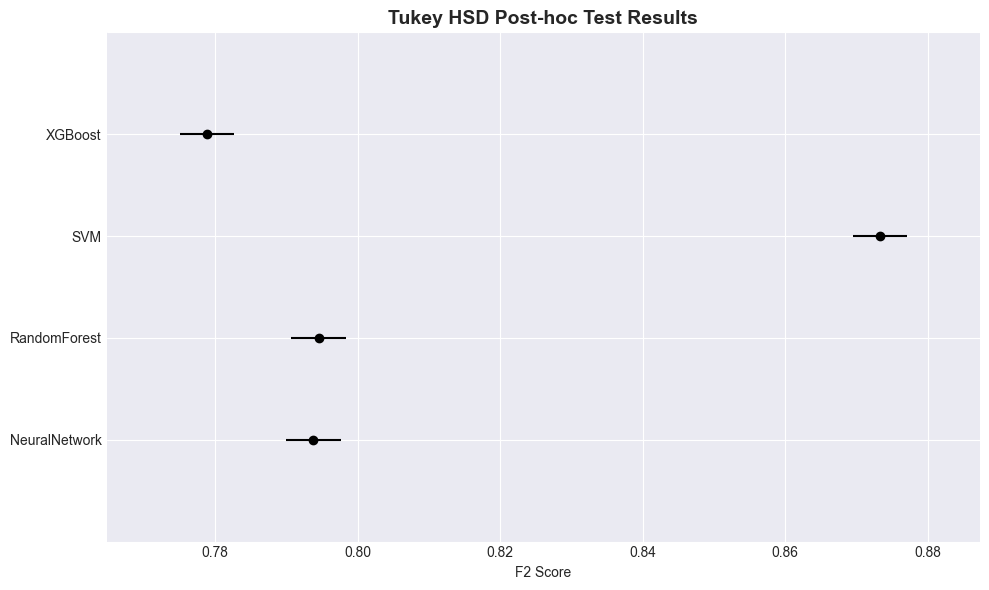

In [8]:
# Perform ANOVA or Friedman test for overall comparison
print("OVERALL MODEL COMPARISON TEST")
print("=" * 70)

# Prepare data for overall test
f2_data = []
model_names = []
for model in all_models_df['Model'].unique():
    f2_data.append(all_models_df[all_models_df['Model'] == model]['F2_Score'].values)
    model_names.append(model)

# Check if all groups are normally distributed
all_normal = all([shapiro_results[model]['F2_Score']['normal'] for model in model_names])

if all_normal:
    print("\nAll models have normally distributed F2 scores.")
    print("Performing One-Way Repeated Measures ANOVA...")
    
    # Since we have paired measurements (same folds), we need repeated measures
    # We'll use a one-way ANOVA for repeated measures
    from statsmodels.stats.anova import AnovaRM
    
    # Prepare data for AnovaRM
    anova_data = pd.DataFrame()
    for i, model in enumerate(model_names):
        temp_df = pd.DataFrame({
            'subject': range(len(f2_data[i])),
            'model': model,
            'score': f2_data[i]
        })
        anova_data = pd.concat([anova_data, temp_df])
    
    # Perform repeated measures ANOVA
    anova_rm = AnovaRM(anova_data, 'score', 'subject', within=['model'])
    anova_results = anova_rm.fit()
    
    print("\nRepeated Measures ANOVA Results:")
    print(anova_results)
    
    f_stat = anova_results.anova_table['F Value'][0]
    p_value = anova_results.anova_table['Pr > F'][0]
    test_used = "Repeated Measures ANOVA"
    
else:
    print("\nNot all models have normally distributed F2 scores.")
    print("Performing Friedman Test (non-parametric alternative)...")
    
    # Perform Friedman test
    # Transpose data to have shape (n_subjects, n_groups)
    friedman_data = np.array(f2_data).T
    
    friedman_stat, friedman_p = stats.friedmanchisquare(*friedman_data.T)
    
    print(f"\nFriedman Test Results:")
    print(f"Chi-square statistic: {friedman_stat:.4f}")
    print(f"p-value: {friedman_p:.4f}")
    
    f_stat = friedman_stat
    p_value = friedman_p
    test_used = "Friedman Test"

# Visualize overall test results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f'Overall Model Comparison: {test_used}', fontsize=16, fontweight='bold')

# Plot 1: F2 Score distributions
sns.violinplot(x='Model', y='F2_Score', data=all_models_df, ax=axes[0])
sns.stripplot(x='Model', y='F2_Score', data=all_models_df, 
              ax=axes[0], color='black', alpha=0.5, size=3)
axes[0].set_title('F2 Score Distribution by Model', fontsize=12)
axes[0].set_ylabel('F2 Score')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Test results
axes[1].axis('off')
result_text = f"""
{test_used} Results:

Test Statistic: {f_stat:.4f}
p-value: {p_value:.4f}

Significant difference
between models?
{"YES" if p_value < 0.05 else "NO"}

α-level: 0.05
"""

color = 'lightgreen' if p_value < 0.05 else 'lightcoral'
axes[1].text(0.5, 0.5, result_text, ha='center', va='center', fontsize=12,
            bbox=dict(boxstyle="round,pad=1", facecolor=color, alpha=0.7))

# Plot 3: Mean F2 scores with confidence intervals
mean_f2 = all_models_df.groupby('Model')['F2_Score'].mean()
std_f2 = all_models_df.groupby('Model')['F2_Score'].std()
ci_f2 = 1.96 * std_f2 / np.sqrt(20)  # 95% CI

x_pos = np.arange(len(mean_f2))
axes[2].errorbar(x_pos, mean_f2, yerr=ci_f2, fmt='o', color='blue', 
                ecolor='red', elinewidth=2, capsize=5, capthick=2)
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(mean_f2.index, rotation=45)
axes[2].set_ylabel('F2 Score')
axes[2].set_title('Mean F2 Scores with 95% CI', fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Post-hoc tests if overall test is significant
if p_value < 0.05:
    print("\n" + "=" * 70)
    print("POST-HOC ANALYSIS (Overall test was significant)")
    print("=" * 70)
    
    if test_used == "Repeated Measures ANOVA":
        print("\nPerforming Tukey HSD post-hoc test...")
        
        # Prepare data for Tukey
        tukey_data = all_models_df[['Model', 'F2_Score']].copy()
        tukey_data['subject'] = np.tile(range(20), 4)  # Assuming 20 folds per model
        
        tukey_result = pairwise_tukeyhsd(tukey_data['F2_Score'], tukey_data['Model'], alpha=0.05)
        print(tukey_result)
        
        # Visualize Tukey results
        fig, ax = plt.subplots(figsize=(10, 6))
        tukey_result.plot_simultaneous(ax=ax)
        ax.set_title('Tukey HSD Post-hoc Test Results', fontsize=14, fontweight='bold')
        ax.set_xlabel('F2 Score')
        plt.tight_layout()
        plt.show()
        
    else:  # Friedman test
        print("\nPerforming Nemenyi post-hoc test...")
        
        # Prepare data for Nemenyi
        posthoc_data = np.array(f2_data).T
        posthoc_df = pd.DataFrame(posthoc_data, columns=model_names)
        
        nemenyi_result = sp.posthoc_nemenyi_friedman(posthoc_df)
        
        print("\nNemenyi test p-values matrix:")
        print(nemenyi_result)
        
        # Visualize Nemenyi results
        fig, ax = plt.subplots(figsize=(8, 6))
        mask = np.triu(np.ones_like(nemenyi_result, dtype=bool))
        cmap = sns.diverging_palette(220, 20, as_cmap=True)
        sns.heatmap(nemenyi_result, annot=True, fmt=".4f", cmap=cmap, 
                    center=0.05, square=True, linewidths=1, 
                    cbar_kws={"label": "p-value"}, ax=ax)
        ax.set_title('Nemenyi Post-hoc Test Results', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

In [9]:
print("PAIRWISE COMPARISONS: SVM vs Each Other Model")
print("=" * 70)

# Define the comparison pairs (SVM vs each other model)
comparison_pairs = [
    ('SVM', 'RandomForest'),
    ('SVM', 'NeuralNetwork'),
    ('SVM', 'XGBoost')
]

# Store results
pairwise_results = []

# Perform pairwise comparisons
for model1, model2 in comparison_pairs:
    print(f"\n{'='*40}")
    print(f"COMPARISON: {model1} vs {model2}")
    print(f"{'='*40}")
    
    # Get data for both models
    data1 = all_models_df[all_models_df['Model'] == model1]['F2_Score'].values
    data2 = all_models_df[all_models_df['Model'] == model2]['F2_Score'].values
    
    # Calculate descriptive statistics
    mean1, std1 = np.mean(data1), np.std(data1)
    mean2, std2 = np.mean(data2), np.std(data2)
    mean_diff = mean1 - mean2
    
    # Check normality of differences
    differences = data1 - data2
    shapiro_stat, shapiro_p = stats.shapiro(differences)
    diff_normal = shapiro_p > 0.05
    
    # Perform appropriate test based on normality
    if diff_normal:
        # Paired t-test
        test_stat, test_p = stats.ttest_rel(data1, data2)
        test_used = "Paired t-test"
    else:
        # Wilcoxon signed-rank test
        test_stat, test_p = stats.wilcoxon(data1, data2)
        test_used = "Wilcoxon signed-rank test"
    
    # Calculate effect size (Cohen's d for paired samples)
    cohen_d = np.mean(differences) / np.std(differences, ddof=1)
    
    # Calculate 95% confidence interval for mean difference
    n = len(differences)
    se_diff = np.std(differences, ddof=1) / np.sqrt(n)
    ci_lower = mean_diff - 1.96 * se_diff
    ci_upper = mean_diff + 1.96 * se_diff
    
    # Store results
    result = {
        'Comparison': f'{model1} vs {model2}',
        'Model1_Mean': mean1,
        'Model1_Std': std1,
        'Model2_Mean': mean2,
        'Model2_Std': std2,
        'Mean_Difference': mean_diff,
        'CI_Lower': ci_lower,
        'CI_Upper': ci_upper,
        'Test_Used': test_used,
        'Test_Statistic': test_stat,
        'P_Value': test_p,
        'Cohen_d': cohen_d,
        'Diff_Normal': diff_normal,
        'Significant': test_p < 0.05
    }
    
    pairwise_results.append(result)
    
    # Print results
    print(f"\nDescriptive Statistics:")
    print(f"  {model1}: {mean1:.4f} ± {std1:.4f}")
    print(f"  {model2}: {mean2:.4f} ± {std2:.4f}")
    print(f"  Mean Difference: {mean_diff:.4f} (95% CI: [{ci_lower:.4f}, {ci_upper:.4f}])")
    
    print(f"\nNormality of Differences:")
    print(f"  Shapiro-Wilk p-value: {shapiro_p:.4f}")
    print(f"  Differences are {'NORMAL' if diff_normal else 'NOT NORMAL'}")
    
    print(f"\nStatistical Test ({test_used}):")
    print(f"  Test Statistic: {test_stat:.4f}")
    print(f"  p-value: {test_p:.4f}")
    print(f"  Significant at α=0.05? {'YES' if test_p < 0.05 else 'NO'}")
    
    print(f"\nEffect Size:")
    print(f"  Cohen's d: {cohen_d:.4f}")
    print(f"  Effect Size Interpretation: ", end="")
    if abs(cohen_d) < 0.2:
        print("Negligible")
    elif abs(cohen_d) < 0.5:
        print("Small")
    elif abs(cohen_d) < 0.8:
        print("Medium")
    else:
        print("Large")

# Apply Bonferroni correction for multiple comparisons
print(f"\n{'='*70}")
print("MULTIPLE COMPARISONS CORRECTION")
print(f"{'='*70}")

alpha = 0.05
n_comparisons = len(comparison_pairs)
bonferroni_alpha = alpha / n_comparisons

print(f"\nNumber of comparisons: {n_comparisons}")
print(f"Original alpha level: {alpha}")
print(f"Bonferroni corrected alpha: {bonferroni_alpha:.6f}")

print(f"\nSignificance after Bonferroni correction:")
for i, result in enumerate(pairwise_results):
    comparison = result['Comparison']
    p_value = result['P_Value']
    sig_bonferroni = p_value < bonferroni_alpha
    
    print(f"  {comparison}: p = {p_value:.6f}, Significant? {'YES' if sig_bonferroni else 'NO'}")

# Create DataFrame of results
pairwise_df = pd.DataFrame(pairwise_results)

PAIRWISE COMPARISONS: SVM vs Each Other Model

COMPARISON: SVM vs RandomForest

Descriptive Statistics:
  SVM: 0.8733 ± 0.0037
  RandomForest: 0.7945 ± 0.0073
  Mean Difference: 0.0788 (95% CI: [0.0763, 0.0813])

Normality of Differences:
  Shapiro-Wilk p-value: 0.7578
  Differences are NORMAL

Statistical Test (Paired t-test):
  Test Statistic: 61.3742
  p-value: 0.0000
  Significant at α=0.05? YES

Effect Size:
  Cohen's d: 13.7237
  Effect Size Interpretation: Large

COMPARISON: SVM vs NeuralNetwork

Descriptive Statistics:
  SVM: 0.8733 ± 0.0037
  NeuralNetwork: 0.7938 ± 0.0146
  Mean Difference: 0.0795 (95% CI: [0.0734, 0.0856])

Normality of Differences:
  Shapiro-Wilk p-value: 0.4994
  Differences are NORMAL

Statistical Test (Paired t-test):
  Test Statistic: 25.5149
  p-value: 0.0000
  Significant at α=0.05? YES

Effect Size:
  Cohen's d: 5.7053
  Effect Size Interpretation: Large

COMPARISON: SVM vs XGBoost

Descriptive Statistics:
  SVM: 0.8733 ± 0.0037
  XGBoost: 0.7788 ± 0

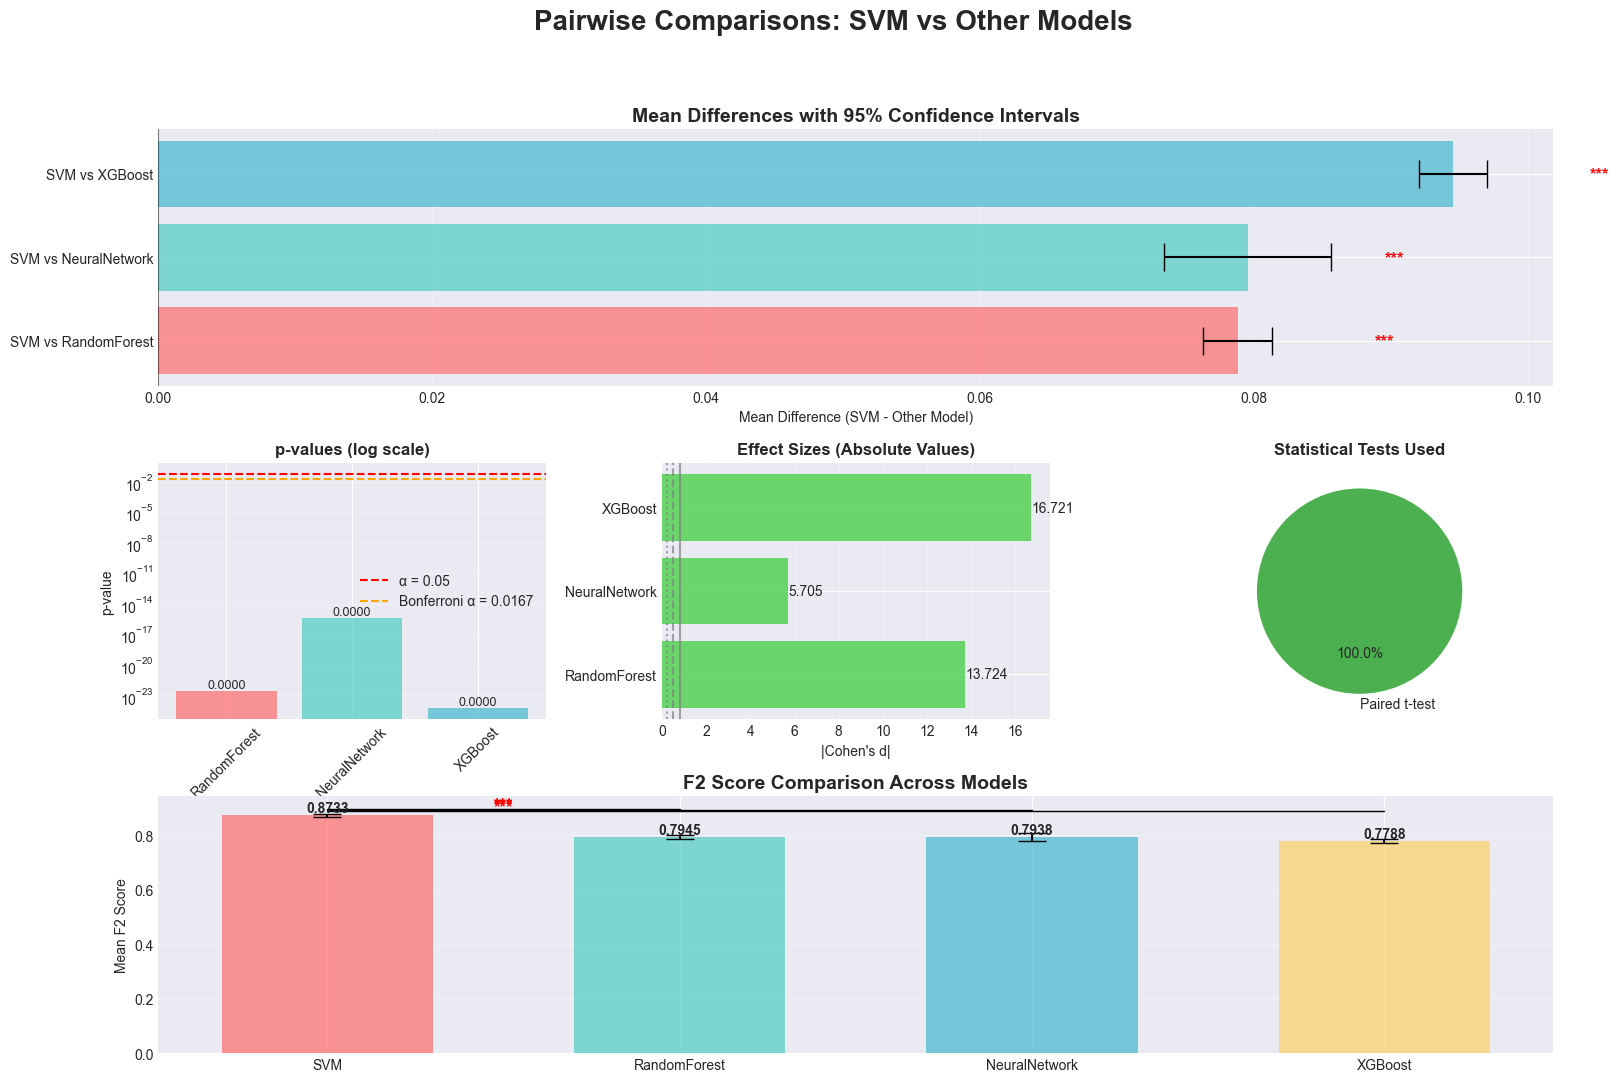


PAIRWISE COMPARISON SUMMARY TABLE

,           Comparison  Model1_Mean  Model2_Mean  Mean_Difference     Test_Used  P_Value  Cohen_d  Significant
 SVM vs RandomForest       0.8733       0.7945           0.0788 Paired t-test      0.0  13.7237         True
SVM vs NeuralNetwork       0.8733       0.7938           0.0795 Paired t-test      0.0   5.7053         True
      SVM vs XGBoost       0.8733       0.7788           0.0945 Paired t-test      0.0  16.7206         True


In [19]:
# Create comprehensive visualization of pairwise comparisons
fig = plt.figure(figsize=(18, 12))
fig.suptitle('Pairwise Comparisons: SVM vs Other Models', fontsize=20, fontweight='bold')

# Create grid specification
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Mean differences with confidence intervals
ax1 = fig.add_subplot(gs[0, :])
comparisons = pairwise_df['Comparison']
mean_diffs = pairwise_df['Mean_Difference']
ci_lower = pairwise_df['CI_Lower']
ci_upper = pairwise_df['CI_Upper']

# Calculate error bars
yerr_lower = mean_diffs - ci_lower
yerr_upper = ci_upper - mean_diffs
yerr = [yerr_lower, yerr_upper]

bars = ax1.barh(range(len(comparisons)), mean_diffs, xerr=yerr, 
                capsize=10, alpha=0.7, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax1.axvline(x=0, color='black', linestyle='-', alpha=0.5)
ax1.set_yticks(range(len(comparisons)))
ax1.set_yticklabels(comparisons)
ax1.set_xlabel('Mean Difference (SVM - Other Model)')
ax1.set_title('Mean Differences with 95% Confidence Intervals', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Add significance stars
for i, (bar, p_val) in enumerate(zip(bars, pairwise_df['P_Value'])):
    height = bar.get_height()
    width = bar.get_width()
    
    if p_val < 0.001:
        sig_text = '***'
    elif p_val < 0.01:
        sig_text = '**'
    elif p_val < 0.05:
        sig_text = '*'
    else:
        sig_text = 'ns'
    
    x_pos = width + (0.01 if width > 0 else -0.01)
    ax1.text(x_pos, i, sig_text, va='center', fontweight='bold', fontsize=12,
            color='red' if sig_text != 'ns' else 'gray')

# 2. p-values visualization
ax2 = fig.add_subplot(gs[1, 0])
x_pos = np.arange(len(comparisons))
p_values = pairwise_df['P_Value']

bars2 = ax2.bar(x_pos, p_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.7)
ax2.axhline(y=0.05, color='red', linestyle='--', label='α = 0.05')
ax2.axhline(y=bonferroni_alpha, color='orange', linestyle='--', 
           label=f'Bonferroni α = {bonferroni_alpha:.4f}')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([c.split(' vs ')[1] for c in comparisons], rotation=45)
ax2.set_ylabel('p-value')
ax2.set_yscale('log')
ax2.set_title('p-values (log scale)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Add p-value labels
for bar, p_val in zip(bars2, p_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{p_val:.4f}', 
            ha='center', va='bottom', fontsize=9)

# 3. Effect sizes
ax3 = fig.add_subplot(gs[1, 1])
cohen_d_values = pairwise_df['Cohen_d'].abs()

# Color code by effect size
colors_effect = []
for d in cohen_d_values:
    if d < 0.2:
        colors_effect.append('#FFCCCB')  # Light red for negligible
    elif d < 0.5:
        colors_effect.append('#FFD700')  # Gold for small
    elif d < 0.8:
        colors_effect.append('#90EE90')  # Light green for medium
    else:
        colors_effect.append('#32CD32')  # Lime green for large

bars3 = ax3.barh(range(len(comparisons)), cohen_d_values, color=colors_effect, alpha=0.7)
ax3.axvline(x=0.2, color='gray', linestyle=':', alpha=0.7)
ax3.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7)
ax3.axvline(x=0.8, color='gray', linestyle='-', alpha=0.7)
ax3.set_yticks(range(len(comparisons)))
ax3.set_yticklabels([c.split(' vs ')[1] for c in comparisons])
ax3.set_xlabel("|Cohen's d|")
ax3.set_title("Effect Sizes (Absolute Values)", fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# Add effect size labels
for i, (bar, d_val) in enumerate(zip(bars3, cohen_d_values)):
    width = bar.get_width()
    ax3.text(width + 0.02, i, f'{d_val:.3f}', va='center', fontsize=10)

# 4. Test type used
ax4 = fig.add_subplot(gs[1, 2])
test_types = pairwise_df['Test_Used']
normality = pairwise_df['Diff_Normal']

# Count test types
test_counts = pd.Series(test_types).value_counts()
colors_test = ['#4CAF50' if 't-test' in t else '#2196F3' for t in test_counts.index]

ax4.pie(test_counts.values, labels=test_counts.index, autopct='%1.1f%%', 
        colors=colors_test, startangle=90)
ax4.set_title('Statistical Tests Used', fontsize=12, fontweight='bold')

# 5. Side-by-side comparison
ax5 = fig.add_subplot(gs[2, :])

# Prepare data for grouped bar chart
models_to_compare = ['SVM'] + [pair[1] for pair in comparison_pairs]
mean_f2_scores = []
std_f2_scores = []

for model in models_to_compare:
    data = all_models_df[all_models_df['Model'] == model]['F2_Score']
    mean_f2_scores.append(data.mean())
    std_f2_scores.append(data.std())

x = np.arange(len(models_to_compare))
width = 0.6

bars5 = ax5.bar(x, mean_f2_scores, width, yerr=std_f2_scores, 
                capsize=10, alpha=0.7, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFD166'])
ax5.set_xticks(x)
ax5.set_xticklabels(models_to_compare)
ax5.set_ylabel('Mean F2 Score')
ax5.set_title('F2 Score Comparison Across Models', fontsize=14, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

# Add mean values on bars
for bar, mean_val in zip(bars5, mean_f2_scores):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 0.001, f'{mean_val:.4f}', 
            ha='center', va='bottom', fontweight='bold')

# Add comparison lines and significance
y_max = max(mean_f2_scores) + max(std_f2_scores) + 0.01
for i, (comp, p_val) in enumerate(zip(comparisons, pairwise_df['P_Value'])):
    y_pos = y_max - i * 0.005
    
    if p_val < 0.001:
        sig_text = '***'
    elif p_val < 0.01:
        sig_text = '**'
    elif p_val < 0.05:
        sig_text = '*'
    else:
        sig_text = 'ns'
    
    # Draw line between SVM and other model
    ax5.plot([0, i+1], [y_pos, y_pos], 'k-', linewidth=1)
    ax5.text(0.5, y_pos + 0.001, sig_text, ha='center', fontweight='bold',
            color='red' if sig_text != 'ns' else 'gray', fontsize=12)

plt.tight_layout()
plt.show()

# Print summary table
print("\n" + "=" * 70)
print("PAIRWISE COMPARISON SUMMARY TABLE")
print("=" * 70)

summary_table = pairwise_df[[
    'Comparison', 
    'Model1_Mean', 
    'Model2_Mean', 
    'Mean_Difference',
    'Test_Used',
    'P_Value',
    'Cohen_d',
    'Significant'
]].copy()

summary_table['Model1_Mean'] = summary_table['Model1_Mean'].round(4)
summary_table['Model2_Mean'] = summary_table['Model2_Mean'].round(4)
summary_table['Mean_Difference'] = summary_table['Mean_Difference'].round(4)
summary_table['P_Value'] = summary_table['P_Value'].round(6)
summary_table['Cohen_d'] = summary_table['Cohen_d'].round(4)

print(f'\n, {summary_table.to_string(index=False)}')

FINAL MODEL RANKING AND RECOMMENDATIONS

MODEL RANKING BASED ON F2 SCORE:
--------------------------------------------------
                 mean     std     min     max  Rank
Model                                              
SVM            0.8733  0.0038  0.8684  0.8809     1
RandomForest   0.7945  0.0075  0.7832  0.8062     2
NeuralNetwork  0.7938  0.0150  0.7706  0.8216     3
XGBoost        0.7788  0.0063  0.7676  0.7869     4


STATISTICAL SIGNIFICANCE SUMMARY:
--------------------------------------------------

SVM vs RandomForest:
  p-value: 0.000000
  Cohen's d: 13.7237
  Conclusion: SVM is SIGNIFICANTLY BETTER than RandomForest

SVM vs NeuralNetwork:
  p-value: 0.000000
  Cohen's d: 5.7053
  Conclusion: SVM is SIGNIFICANTLY BETTER than NeuralNetwork

SVM vs XGBoost:
  p-value: 0.000000
  Cohen's d: 16.7206
  Conclusion: SVM is SIGNIFICANTLY BETTER than XGBoost


FINAL RECOMMENDATIONS:
--------------------------------------------------
1. BEST PERFORMING MODEL: SVM
   - Mean 

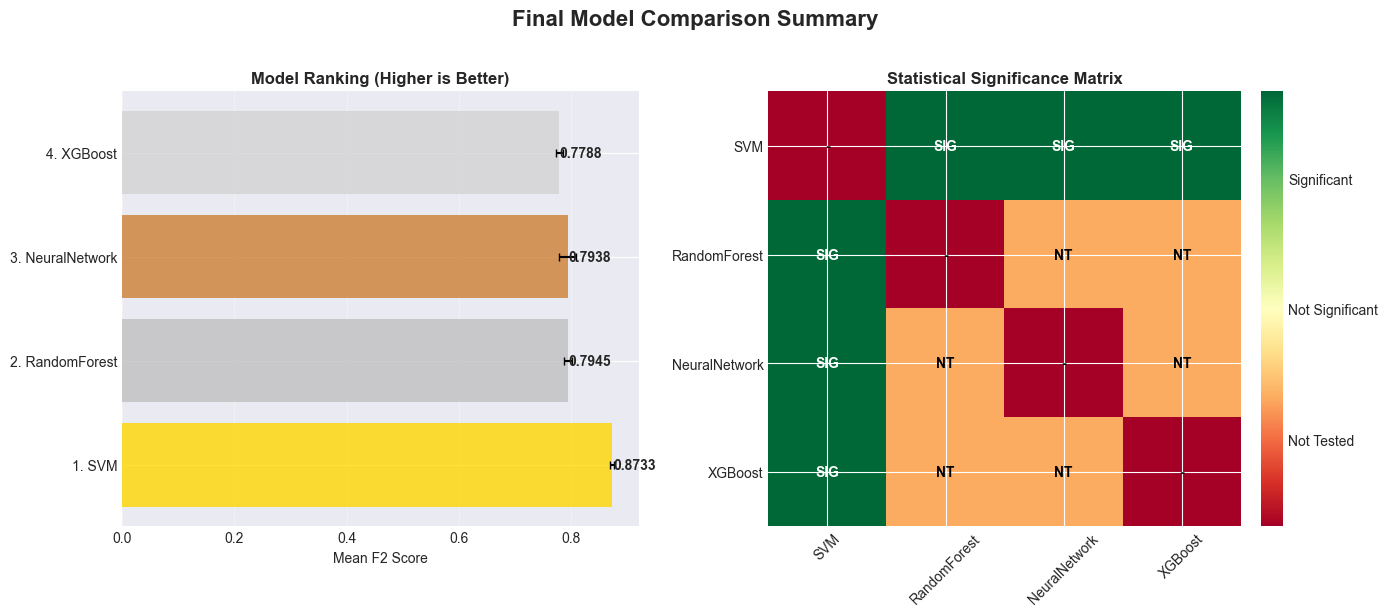


ANALYSIS COMPLETE - Export results as needed


In [20]:
print("FINAL MODEL RANKING AND RECOMMENDATIONS")
print("=" * 70)

# Calculate overall rankings based on F2 score
model_ranking = all_models_df.groupby('Model')['F2_Score'].agg(['mean', 'std', 'min', 'max']).round(4)
model_ranking = model_ranking.sort_values('mean', ascending=False)
model_ranking['Rank'] = range(1, len(model_ranking) + 1)

print("\nMODEL RANKING BASED ON F2 SCORE:")
print("-" * 50)
print(model_ranking)

# Statistical significance ranking
print("\n\nSTATISTICAL SIGNIFICANCE SUMMARY:")
print("-" * 50)

for idx, (model1, model2) in enumerate(comparison_pairs):
    p_val = pairwise_df.loc[idx, 'P_Value']
    sig = pairwise_df.loc[idx, 'Significant']
    cohen_d = pairwise_df.loc[idx, 'Cohen_d']
    
    if sig:
        if cohen_d > 0:
            conclusion = f"{model1} is SIGNIFICANTLY BETTER than {model2}"
        else:
            conclusion = f"{model1} is SIGNIFICANTLY WORSE than {model2}"
    else:
        conclusion = f"No significant difference between {model1} and {model2}"
    
    print(f"\n{model1} vs {model2}:")
    print(f"  p-value: {p_val:.6f}")
    print(f"  Cohen's d: {cohen_d:.4f}")
    print(f"  Conclusion: {conclusion}")

# Final recommendations
print("\n\nFINAL RECOMMENDATIONS:")
print("-" * 50)

best_model = model_ranking.index[0]
best_mean = model_ranking.iloc[0]['mean']
best_std = model_ranking.iloc[0]['std']

print(f"1. BEST PERFORMING MODEL: {best_model}")
print(f"   - Mean F2 Score: {best_mean:.4f} ± {best_std:.4f}")
print(f"   - Rank: #1 out of {len(model_ranking)} models")

# Check if best model is significantly better than others
print("\n2. STATISTICAL SIGNIFICANCE:")
if best_model == 'SVM':
    # Check if SVM is significantly better than others
    sig_better = []
    not_sig = []
    
    for idx, (model1, model2) in enumerate(comparison_pairs):
        if model1 == 'SVM':
            p_val = pairwise_df.loc[idx, 'P_Value']
            cohen_d = pairwise_df.loc[idx, 'Cohen_d']
            
            if pairwise_df.loc[idx, 'Significant'] and cohen_d > 0:
                sig_better.append(model2)
            else:
                not_sig.append(model2)
    
    if sig_better:
        print(f"   - SVM is significantly better than: {', '.join(sig_better)}")
    if not_sig:
        print(f"   - No significant difference with: {', '.join(not_sig)}")
else:
    print(f"   - {best_model} outperformed SVM, but check pairwise comparisons for significance")

print("\n3. PRACTICAL RECOMMENDATIONS:")
print("   - Consider both statistical significance AND effect size")
print("   - For critical applications, choose the model with highest mean AND statistical significance")
print("   - For balanced performance, consider F1 score and accuracy as well")

# Create final summary visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Final Model Comparison Summary', fontsize=16, fontweight='bold', y=1.02)

# Plot 1: Model ranking
colors = ['gold', 'silver', '#CD7F32', 'lightgray'][:len(model_ranking)]
bars = axes[0].barh(range(len(model_ranking)), model_ranking['mean'], 
                    color=colors, alpha=0.8)
axes[0].set_yticks(range(len(model_ranking)))
axes[0].set_yticklabels([f"{i+1}. {model}" for i, model in enumerate(model_ranking.index)])
axes[0].set_xlabel('Mean F2 Score')
axes[0].set_title('Model Ranking (Higher is Better)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Add values and error bars
for i, (bar, (_, row)) in enumerate(zip(bars, model_ranking.iterrows())):
    width = bar.get_width()
    axes[0].text(width + 0.001, i, f'{row["mean"]:.4f}', va='center', fontweight='bold')
    # Add error bar
    axes[0].errorbar(width, i, xerr=row['std'], fmt='none', ecolor='black', capsize=3)

# Plot 2: Significance matrix
sig_matrix = np.zeros((len(models_to_compare), len(models_to_compare)))
model_list = list(models_to_compare)

# Fill matrix with significance values
for i, model1 in enumerate(model_list):
    for j, model2 in enumerate(model_list):
        if i == j:
            sig_matrix[i, j] = 0  # Diagonal
        else:
            # Find if this comparison exists in our results
            found = False
            for idx, (m1, m2) in enumerate(comparison_pairs):
                if (m1 == model1 and m2 == model2) or (m1 == model2 and m2 == model1):
                    p_val = pairwise_df.loc[idx, 'P_Value']
                    sig_matrix[i, j] = 1 if p_val < 0.05 else 0.5
                    found = True
                    break
            
            if not found:
                sig_matrix[i, j] = 0.3  # Not tested

im = axes[1].imshow(sig_matrix, cmap='RdYlGn', vmin=0, vmax=1, aspect='auto')
axes[1].set_xticks(range(len(model_list)))
axes[1].set_yticks(range(len(model_list)))
axes[1].set_xticklabels(model_list, rotation=45)
axes[1].set_yticklabels(model_list)
axes[1].set_title('Statistical Significance Matrix', fontsize=12, fontweight='bold')

# Add text annotations
for i in range(len(model_list)):
    for j in range(len(model_list)):
        if i == j:
            text = '-'
        else:
            if sig_matrix[i, j] == 1:
                text = 'SIG'
            elif sig_matrix[i, j] == 0.5:
                text = 'NS'
            else:
                text = 'NT'
        color = 'white' if sig_matrix[i, j] > 0.7 else 'black'
        axes[1].text(j, i, text, ha='center', va='center', color=color, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
cbar.set_ticks([0.2, 0.5, 0.8])
cbar.set_ticklabels(['Not Tested', 'Not Significant', 'Significant'])

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("ANALYSIS COMPLETE - Export results as needed")
print("=" * 70)

In [22]:
# Export all analysis results
print("Exporting analysis results...")

# 1. Export raw data for all models
all_models_df.to_csv('results/all_models_comparison_data.csv', index=False)
print("✓ All models data saved to 'results/all_models_comparison_data.csv'")

# 2. Export Shapiro-Wilk results
shapiro_export = []
for model, results in shapiro_results.items():
    for metric, result in results.items():
        shapiro_export.append({
            'Model': model,
            'Metric': metric,
            'W_Statistic': result['statistic'],
            'P_Value': result['p_value'],
            'Normal': result['normal']
        })
pd.DataFrame(shapiro_export).to_csv('results/normality_tests_results.csv', index=False)
print("✓ Normality tests saved to 'results/normality_tests_results.csv'")

# 3. Export pairwise comparison results
pairwise_df.to_csv('results/pairwise_comparisons_detailed.csv', index=False)
print("✓ Pairwise comparisons saved to 'results/pairwise_comparisons_detailed.csv'")

# 4. Export model ranking
model_ranking.to_csv('results/model_ranking.csv')
print("✓ Model ranking saved to 'results/model_ranking.csv'")

# 5. Export summary statistics
summary_stats = all_models_df.groupby('Model').agg({
    'F2_Score': ['mean', 'std', 'min', 'max'],
    'F1_Score': ['mean', 'std'],
    'Accuracy': ['mean', 'std']
}).round(4)
summary_stats.to_csv('results/model_summary_statistics.csv')
print("✓ Summary statistics saved to 'results/model_summary_statistics.csv'")

# 6. Create and export comprehensive report
comprehensive_report = []

for model in all_models_df['Model'].unique():
    model_df = all_models_df[all_models_df['Model'] == model]
    
    report_entry = {
        'Model': model,
        'F2_Mean': model_df['F2_Score'].mean(),
        'F2_Std': model_df['F2_Score'].std(),
        'F1_Mean': model_df['F1_Score'].mean(),
        'F1_Std': model_df['F1_Score'].std(),
        'Accuracy_Mean': model_df['Accuracy'].mean(),
        'Accuracy_Std': model_df['Accuracy'].std(),
        'Rank': int(model_ranking.loc[model, 'Rank']),
        'F2_Normal': shapiro_results[model]['F2_Score']['normal']
    }
    
    # Add comparison results if model is SVM
    if model == 'SVM':
        for idx, (_, other_model) in enumerate(comparison_pairs):
            if idx < len(pairwise_df):
                report_entry[f'vs_{other_model}_pvalue'] = pairwise_df.loc[idx, 'P_Value']
                report_entry[f'vs_{other_model}_cohend'] = pairwise_df.loc[idx, 'Cohen_d']
                report_entry[f'vs_{other_model}_significant'] = pairwise_df.loc[idx, 'Significant']
    
    comprehensive_report.append(report_entry)

pd.DataFrame(comprehensive_report).to_csv('results/comprehensive_model_report.csv', index=False)
print("✓ Comprehensive report saved to 'results/comprehensive_model_report.csv'")

print("\nAll exports completed successfully!")
print(f"Total comparisons performed: {len(comparison_pairs)}")
print(f"Best model: {model_ranking.index[0]} (Mean F2: {model_ranking.iloc[0]['mean']:.4f})")

Exporting analysis results...
✓ All models data saved to 'results/all_models_comparison_data.csv'
✓ Normality tests saved to 'results/normality_tests_results.csv'
✓ Pairwise comparisons saved to 'results/pairwise_comparisons_detailed.csv'
✓ Model ranking saved to 'results/model_ranking.csv'
✓ Summary statistics saved to 'results/model_summary_statistics.csv'
✓ Comprehensive report saved to 'results/comprehensive_model_report.csv'

All exports completed successfully!
Total comparisons performed: 3
Best model: SVM (Mean F2: 0.8733)
